In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from typing import Optional, List, Dict, Any

from panovlm.config import ModelConfig
from panovlm.model import PanoramaVLM
from panovlm.processors.image import PanoramaImageProcessor

def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().permute(1, 2, 0).numpy()
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

def visualize_views(
    pixel_values: torch.Tensor,
    title: str,
    *,  # [핵심 수정] 이 뒤의 인자는 반드시 키워드로만 전달해야 함
    titles: Optional[List[str]] = None,
    filename: Optional[str] = None,
    show_plot: bool = False
):
    """
    Create and save or show a visualization of the processed views.
    Optional arguments after '*' must be passed as keyword arguments.
    """
    if not filename and not show_plot:
        print("Warning: No action taken. Either 'filename' must be provided or 'show_plot' must be True.")
        return

    views = pixel_values.squeeze(0)
    num_views = views.shape[0]
    
    if num_views <= 4:
        nrows, ncols = 1, num_views
    else:
        nrows = 1
        ncols = math.ceil(num_views / 1)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4 + 1))
    axes = np.ravel(axes)
    
    fig.suptitle(title, fontsize=16)
    
    for i in range(num_views):
        view_tensor = views[i]
        img = denormalize(view_tensor)
        axes[i].imshow(img)
        axes[i].axis('off')
        if titles and i < len(titles):
            axes[i].set_title(titles[i])

    for i in range(num_views, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if filename:
        plt.savefig(filename)
        print(f"Saved visualization to {filename}")
    
    if show_plot:
        plt.show()

    plt.close(fig)

checkpoint_path = 'runs/SQ05_test_e2p_finetune_mlp/SQ05_test_e2p_finetune_mlp_00-2.9764.ckpt'
# 설정 시스템을 통한 모델 로딩
if checkpoint_path:
    model = PanoramaVLM.from_checkpoint(checkpoint_path, device="auto")
else:
    config = ModelConfig(
        vision_name="google/siglip-base-patch16-224",
        language_model_name="Qwen/Qwen2.5-1.5B-Instruct", 
        latent_dimension=768
    )

    model = PanoramaVLM(
        config=config,
        resampler_type="mlp",
        latent_dimension=768,
        vicreg_loss_weight=1.0,
        vicreg_overlap_ratio=0.5,
        max_text_length=32,
        use_vicreg_local=False,
).to("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

sample_image = "data/quic360/downtest/images/26286679561_2bc4360f7d_f.jpg"
sample_text = "이 사진에서 가장 눈에 띄는 것은 무엇인가요?"

/data/3_lib/miniconda3/envs/panovlm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 PanoramaVLM 체크포인트 로딩: runs/SQ05_test_e2p_finetune_mlp/SQ05_test_e2p_finetune_mlp_00-2.9764.ckpt
📂 체크포인트 로딩 중...
🔍 설정 파일 발견: /data/1_personal/4_SWWOO/panollava/config.json
✅ 설정 로딩 완료: /data/1_personal/4_SWWOO/panollava/config.json
🔍 설정 파일 자동 감지 성공
🛠️  모델 파라미터:
   - vision_name: google/siglip-base-patch16-224
   - language_model_name: Qwen/Qwen2.5-0.5B-Instruct
   - resampler_type: mlp
   - latent_dimension: 896
   - resampler_depth: 3
   - resampler_hidden_dim: 1536
   - resampler_use_ln: True
   - resampler_num_latents: 32
   - resampler_heads: 8
   - resampler_dropout: 0.1
   - resampler_enable_cross_view: False
   - resampler_num_views: 8
   - vicreg_loss_weight: 1.0
   - vicreg_overlap_ratio: 0.5
   - use_vicreg_norm: True
   - max_text_length: 256
   - vicreg_similarity_weight: 25.0
   - vicreg_variance_weight: 25.0
   - vicreg_covariance_weight: 1.0
🏗️  모델 인스턴스 생성 중...
[Tokenizer Setup] Added 1 special tokens: ['<|vision|>', '<|endoftext|>']
[Tokenizer Setup] Resized embeddings:

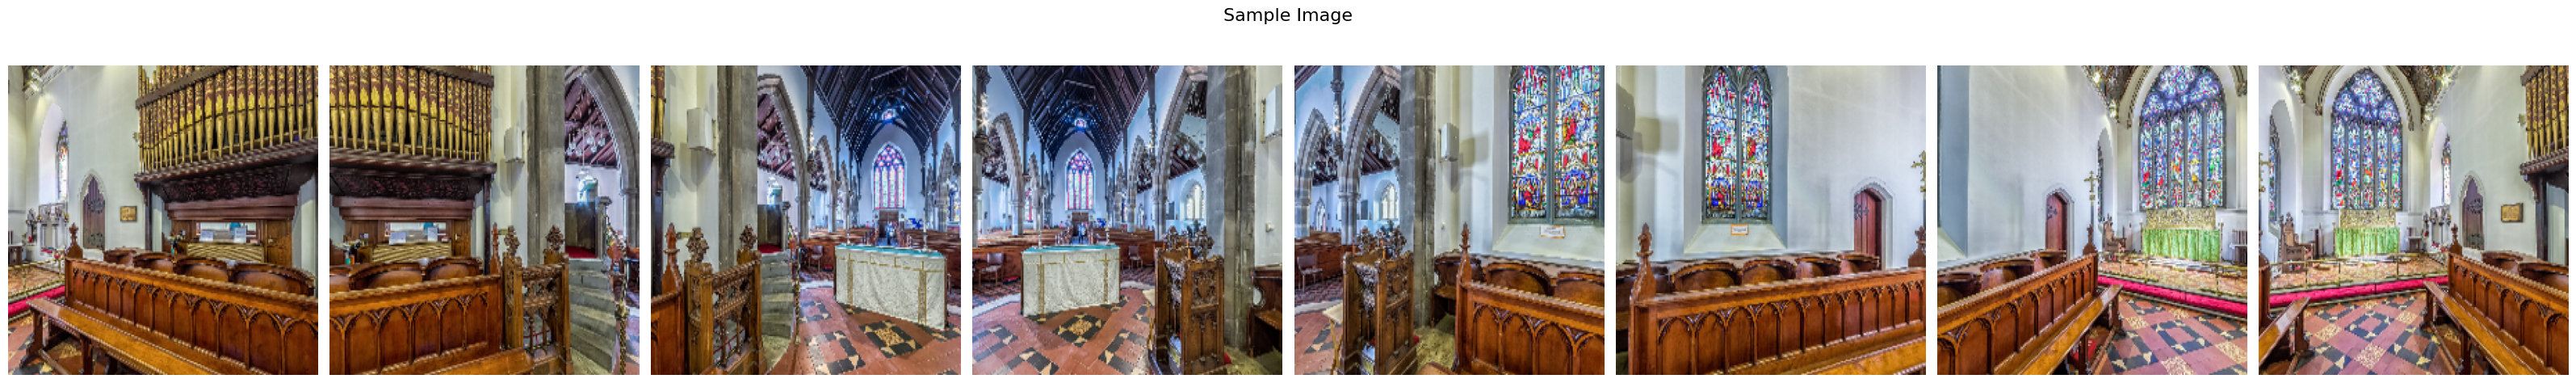

In [2]:
img_proc = PanoramaImageProcessor(
    image_size    =(224, 224),
    crop_strategy ="e2p",   # 또는 "e2p" / "cubemap" /"anyres"/"sliding_window"
    fov_deg       =90,
    overlap_ratio =0.5,
    normalize= True,
    anyres_max_patches=8
)

img = img_proc(sample_image)
img = img.unsqueeze(0)  # 배치 차원 추가
visualize_views(img, title="Sample Image", show_plot=True)

In [3]:
vision_result = model._process_vision_encoder(img.to('cuda'))
vision_features = vision_result["vision_features"]  # [B*V, S, D_vision]
batch_size = vision_result["batch_size"]
num_views = vision_result["num_views"]
            
# 2. Resampler 처리
resampled_features = model._process_resampler(vision_features, batch_size, num_views)  # [B*V, S, D_latent]
            
last_hidden_states = resampled_features.cpu().detach().numpy()

PCA 모델 학습 및 RGB 변환 완료. (공통 스케일링: True)
▶ Hidden-space 유사도 (MSE, Cosine, CKA, Hungarian, Warp-OCS):
  Pair (0, 1): MSE=0.1465, Cos=0.5526, CKA=0.9804, Hung=0.6848
  Pair (1, 2): MSE=0.1475, Cos=0.5511, CKA=0.9810, Hung=0.6673
  Pair (2, 3): MSE=0.1457, Cos=0.5613, CKA=0.9792, Hung=0.7001
  Pair (3, 4): MSE=0.1480, Cos=0.5550, CKA=0.9801, Hung=0.6633
  Pair (4, 5): MSE=0.1481, Cos=0.5560, CKA=0.9763, Hung=0.6901
  Pair (5, 6): MSE=0.1484, Cos=0.5548, CKA=0.9769, Hung=0.6949
  Pair (6, 7): MSE=0.1481, Cos=0.5577, CKA=0.9717, Hung=0.7202
  Pair (7, 0): MSE=0.1481, Cos=0.5562, CKA=0.9740, Hung=0.6718
▶ Hidden-space 유사도 (MSE, Cosine, CKA, Hungarian, Warp-OCS):
  Pair (0, 1): MSE=0.1465, Cos=0.5526, CKA=0.9804, Hung=0.6848, OCS=0.6838
  Pair (1, 2): MSE=0.1475, Cos=0.5511, CKA=0.9810, Hung=0.6673, OCS=0.5856
  Pair (2, 3): MSE=0.1457, Cos=0.5613, CKA=0.9792, Hung=0.7001, OCS=0.6679
  Pair (3, 4): MSE=0.1480, Cos=0.5550, CKA=0.9801, Hung=0.6633, OCS=0.6107
  Pair (4, 5): MSE=0.1481, Cos=0.5560

/data/3_lib/miniconda3/envs/panovlm/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/3_lib/miniconda3/envs/panovlm/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /data/3_lib/miniconda3/envs/panovlm/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
▶ PCA-RGB 유사도 (MSE, SSIM, LPIPS):
⚠️ LPIPS 연산 실패, 제외합니다: Given input size: (64x2x2). Calculated output size: (64x0x0). Output size is too small
  Pair (0, 1): MSE=0.0477, SSIM=0.1750
⚠️ LPIPS 연산 실패, 제외합니다: Given input size: (64x2x2). Calculated output size: (64x0x0). Output size is too small
  Pair (1, 2): MSE=0.0464, SSIM=0.1632
⚠️ LPIPS 연산 실패, 제외합니다: Given input size: (64x2x2). Calculated output size: (64x0x0). Output size is too small
  Pair (2, 3): MSE=0.0546, SSIM=0.1227
⚠️ LPIPS 연산 실패, 제외합니다: Given input size: (64x2x2). Calculated output size: (64x0x0). Output size is too small
  Pair (3, 4): MSE=0.0555, SSIM=0.1598
⚠️ LPIPS 연산 실패, 제외합니다: Given input size: (64x2x2). Calculated output size: (64x0x0). Output size is too small
  Pair (4, 5): MSE=0.0705, SSIM=0.1595
⚠️ LPIPS 연산 실패, 제외합니다: Given input size: (64x2x2). Calculated output size: (64x0x0). Output size is too smal

/data/3_lib/miniconda3/envs/panovlm/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path

대시보드 저장됨: analytics_results/SQ05_test_e2p_finetune_mlp_dashboard.png


/data/1_personal/4_SWWOO/panollava/panovlm/vis/dino.py:820: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # 전체적인 레이아웃 조정


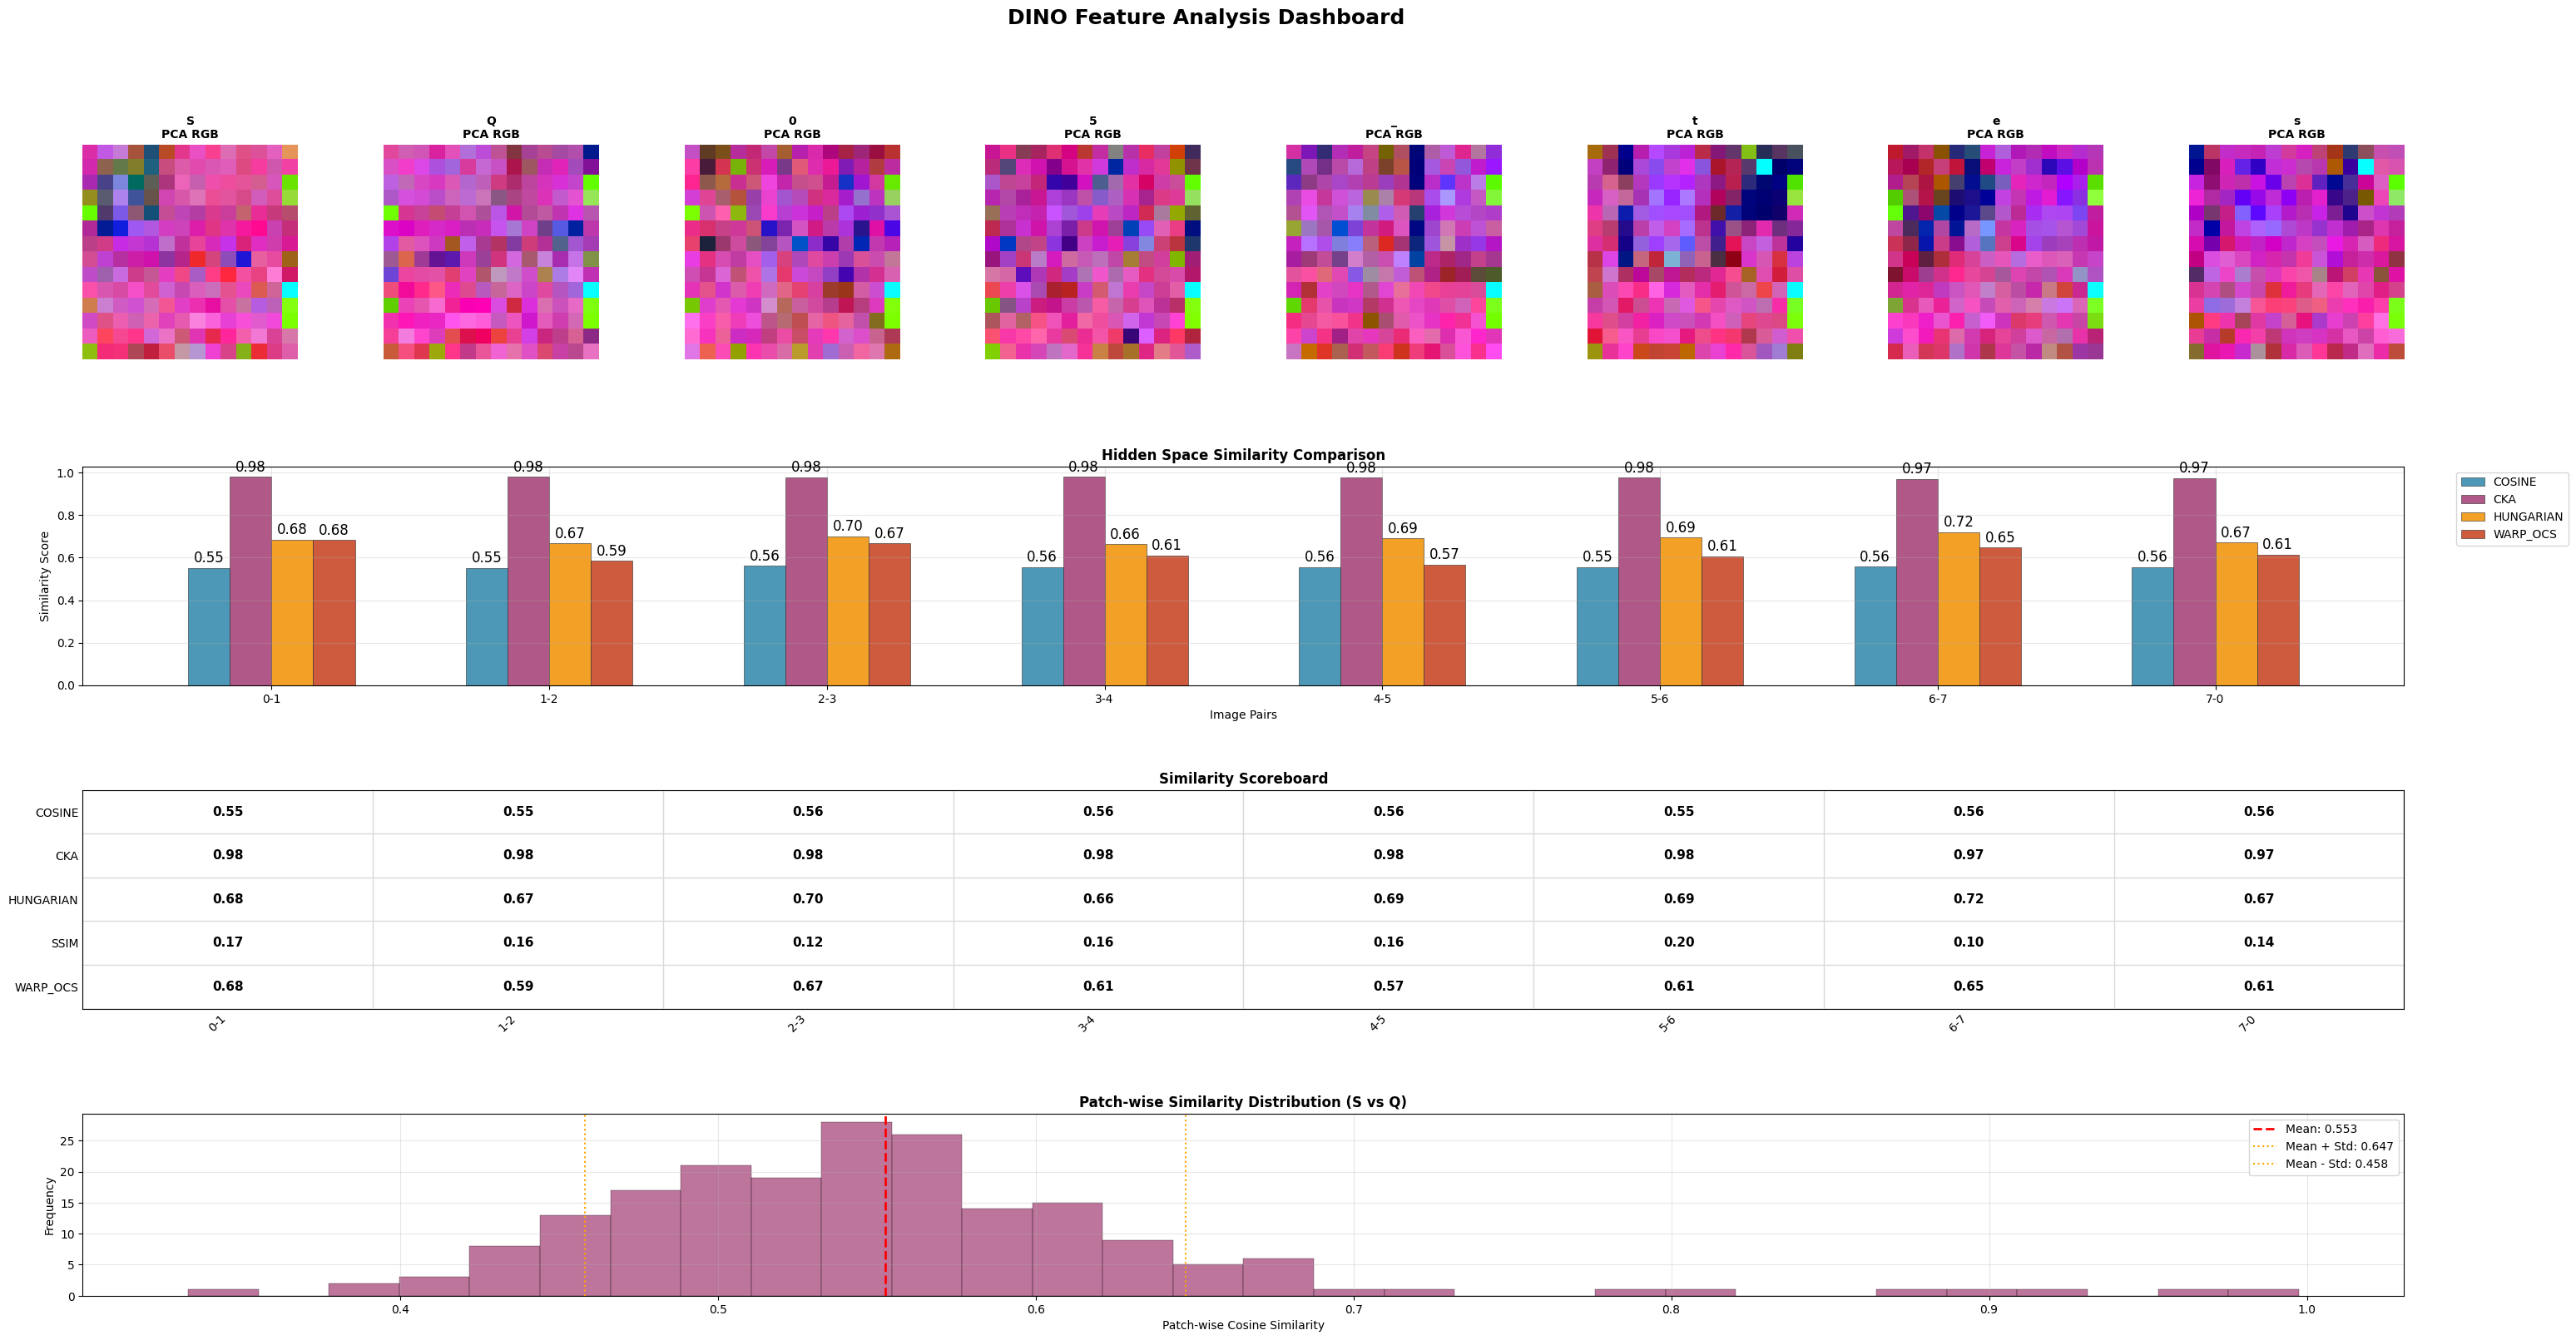

{'hidden_similarity': {'mse': [np.float32(0.14651956),
   np.float32(0.14752305),
   np.float32(0.14567989),
   np.float32(0.14795095),
   np.float32(0.14809379),
   np.float32(0.14843245),
   np.float32(0.14813939),
   np.float32(0.14809187)],
  'cosine': [0.5526482462882996,
   0.5510836839675903,
   0.5613455772399902,
   0.555000901222229,
   0.5559635758399963,
   0.554805338382721,
   0.5577433109283447,
   0.5561584830284119],
  'cka': [0.9804083704948425,
   0.9809706807136536,
   0.9792423844337463,
   0.9801112413406372,
   0.9763434529304504,
   0.9769386053085327,
   0.9717244505882263,
   0.9740038514137268],
  'hungarian': [0.6847791075706482,
   0.6673264503479004,
   0.7001292705535889,
   0.6632500290870667,
   0.6900833249092102,
   0.6949078440666199,
   0.720227062702179,
   0.6718130111694336],
  'warp_ocs': [0.6837865710258484,
   0.5855834484100342,
   0.667931079864502,
   0.610677182674408,
   0.567232608795166,
   0.6066160798072815,
   0.6469796299934387,
   

In [4]:
from panovlm.vis.dino import DinoVisualizer
visualizer = DinoVisualizer(last_hidden_states,remove_cls_token=False)
visualizer.fit_pca(use_global_scaling=True)
visualizer.get_hidden_similarity()
metadata = img_proc.view_metadata  # E2P에서 자동 생성
# similarity = visualizer.get_hidden_similarity(
#     pairs=[(0, 1)], view_metadata=metadata
# )
# visualizer.plot_pca_results(
#     titles=checkpoint_path.split("/")[1],
#     save_path=f"analytics_results/{checkpoint_path.split("/")[1]}.png",
#     )

visualizer.create_comprehensive_dashboard(
    titles=checkpoint_path.split("/")[1],
    view_metadata=metadata,
    save_path=f"analytics_results/{checkpoint_path.split('/')[1]}_dashboard.png"
)